# Деревья решений и композиции

In [ ]:
! pip install shap
import shap
import random
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  # при оценке вашего алгоритма не забудьте разбить данные на тренировочную и тестовую выборки
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # можете сравнить качество вашего алгоритма с реализацией "из коробки"
from sklearn.ensemble import RandomForestClassifier as SklearnRF

В этой лабораторной вам предстоит поработать с классификацией. Задача классификации в машинном обучении - это один из основных типов задач, где модель обучается предсказывать категориальную метку или класс для заданного входного наблюдения на основе обучающего набора данных, содержащего пары "входные данные - целевая метка".

Можно выделить несколько видов классификации:

* Binary - целевой признак имеет метку 0/1;
* Multiclass - целевой признак имеет метку из ограниченного множества (0, 1, 2, 3...);
* Multilabel - целевой признак может иметь несколько меток одновременно.

Классификацию можно решать как задачу регрессии (задача предсказания значения из непрерывного множества), затем выбирая порог - всем значениям меньше порога будет присвоена метка 0, всем значениям выше - метка 1.

# Деревья решений

Решающие деревья - алгоритм машинного обучения, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным.

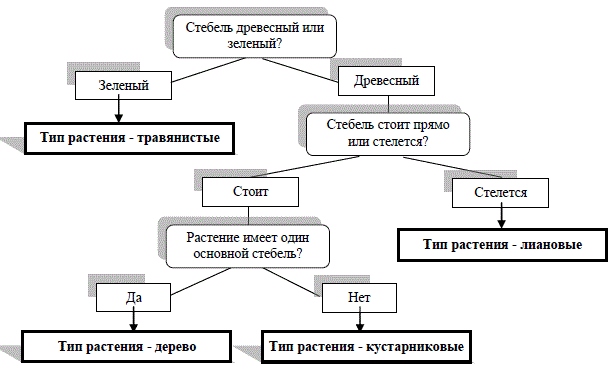

По сути, мы рекурсивно разбиваем наши обучающие данные по значениям определенного столбца, чтобы по итогу в каждом листе оказались наиболее однородные значения целевой переменной.

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$


Небольшое дополнение, чтобы стало понятнее: $Q$ - это функционал, который определяет то, что мы называем "наилучшим разбиением" для данных на каждом шаге. То есть мы выбираем один столбец, потом для него выбираем число $t$ такое, что часть значений столбца меньше $t$, а оставшаяся часть - больше или равна (дерево работает только с числовыми значениями или с категориальными, если они переведены в числовой формат), и смотрим, что случилось с целевой переменной при таком разбиении. Если допустить, что целевая переменная бинарная (0/1) и до разбиения нолики и единички лежали кучей, то после разбиения мы в идеале хотим получить две кучки, где в одной только нули, а в другой только единицы.

## Функционал качества для деревьев решений


Для классификации чаще всего предлагают следующие два:

- энтропия Шеннона: $-\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$,

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.



Оба функционала позволяют определить степень хаоса в системе. Интуитивно:
* 0101101010101 - высокая степень хаоса
* 0000010010000 - средняя степень хаоса
* 0000000000000 - низкая степень хаоса

И с помощью дерева для целевой переменной мы хотим добиться чего-то вроде:
0001100011111 -> 00011000 + 11111 -> 000 + 11000 + 11111 -> 000 + 11 + 000 + 11111

Реализуйте функционалы.

In [ ]:
def entropy(y):  # y - массив значений целевой переменной
    N = len(y)
    y = pd.array(y).value_counts()
    y = y.map(lambda x: - (x / N) * np.log2(x / N))
    return y.sum()


def gini_index(y):
    N = len(y)
    y = pd.array(y).value_counts()
    y = y.map(lambda x: (x / N) **2)
    return 1 - y.sum()

In [ ]:
# Tests

assert np.isclose(entropy([0, 1, 0, 1, 0, 1]), 1.0)
assert np.isclose(entropy([0, 0, 0, 0, 0, 1]), 0.65, rtol=1e5)
assert np.isclose(entropy([0, 1, 2, 0, 1, 2, 0, 1, 2]), 1.58, rtol=1e5)

assert np.isclose(gini_index([0, 1, 0, 1, 0, 1]), 0.5)
assert np.isclose(gini_index([0, 0, 0, 0, 0, 1]), 0.27, rtol=1e5)
assert np.isclose(gini_index([0, 1, 2, 0, 1, 2, 0, 1, 2]), 0.66, rtol=1e5)

assert entropy([0, 0, 0, 0, 0, 0]) == gini_index([0, 0, 0, 0, 0, 0]) == 0.0

print("All tests passed successfully!")

All tests passed successfully!


Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


## Задание 1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

В классе `Tree` реализуйте метод `predict` (на вход метода подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою). Обратите внимание на то, что классы в датасете представлены одинаковым количеством объектов.

In [ ]:
class TreeNode:

  # Инициализация
  def __init__(self, R, y, depth=0, left=None, right=None, split_feature=None, split_threshold=None):
    self.R = R                                             # данные/признаки
    self.y = y                                             # метки класса
    self.depth = depth                                     # глубина данного узла (корень - 0)
    self.left = left                                       # левый дочерний узел (объект класса TreeNode)
    self.right = right                                     # левый дочерний узел (объект класса TreeNode)
    self.split_feature = split_feature                     # признака, по которому происходит разделение
    self.split_threshold = split_threshold                 # пороговое значение для разделения
    self.is_leaf = False                                   # лист ли данный узел
    self.prediction = None                                 # значение для листа (предсказание)

  # Энтропия Шеннона (H)
  def entropy(self, y):
    N = len(y)
    y = pd.array(y).value_counts()
    y = y.map(lambda x: - (x / N) * np.log2(x / N))
    return y.sum()

  # Разделение узла по признаку и порогу
  def separate(self, feature, threshold):
    left_ind = self.R[feature] <= threshold
    right_ind = self.R[feature] > threshold

    R_left = self.R[left_ind]
    y_left = self.y[left_ind]
    R_right = self.R[right_ind]
    y_right = self.y[right_ind]

    return R_left, y_left, R_right, y_right

  # Подсчёт функционала качества IG
  def IG(self, y_left, y_right):
    y_total = np.concatenate([y_left, y_right])
    n_left = len(y_left)
    n_right = len(y_right)
    n_total = n_left + n_right
    return self.entropy(y_total) - (n_left * self.entropy(y_left) + n_right * self.entropy(y_right)) / n_total

  # Выбор наилучшего разделения по признаку и пороговому уровню
  def choice_separate(self):
    best_ig = -np.inf
    best_feature = None
    best_threshold = None

    for feature in self.R.columns:
      values = self.R[feature].unique()
      for threshold in values:
         R_left, y_left, R_right, y_right = self.separate(feature, threshold)
         now_ig = self.IG(y_left, y_right)

         if now_ig > best_ig:
          best_ig = now_ig
          best_feature = feature
          best_threshold = threshold

    return best_feature, best_threshold

  # Проверка критериев остановки
  def check_stop(self, max_depth, min_samples_leaf):
    # Максимальная глубина
    if self.depth >= max_depth:
      return True

    # Минимальное число объектов в листе
    if len(self.y) <= min_samples_leaf:
      return True

    # Purity (все объекты одного класса)
    if len(np.unique(self.y)) == 1:
      return True

    return False

  # Назначает узлу статус листа
  def make_leaf(self):
    self.is_leaf = True
    unique, counts = np.unique(self.y, return_counts=True)
    self.prediction = unique[np.argmax(counts)]



class Tree:

  # Инициализация
  def __init__(self, max_depth=5, min_samples_leaf=5):            # подаются переменные для критериев остановки
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.root = None                                              # корневой узел

  def fit(self, X, y):
    self.root = TreeNode(X, y)                                    # создание корня
    self._grow_tree(self.root)


  # построения дерева (рекурсия)
  def _grow_tree(self, node):
    # Проверка критериев остановки
    if node.check_stop(self.max_depth, self.min_samples_leaf):
      node.make_leaf()
      return

    # Ищем разделение и устанавливаем значения узлу
    feature, threshold = node.choice_separate()
    node.split_feature, node.split_threshold = feature, threshold

    # Разделение данных
    R_left, y_left, R_right, y_right = node.separate(feature, threshold)

    # Создание дочерних узлов
    node.left = TreeNode(R_left, y_left, node.depth + 1)
    node.right = TreeNode(R_right, y_right, node.depth + 1)

    # Поддеревья
    self._grow_tree(node.left)
    self._grow_tree(node.right)


  def predict(self, X):
    predictions = []
    for _, row in X.iterrows():
      node = self.root
      # Спуск до листа
      while not node.is_leaf:
        if row[node.split_feature] <= node.split_threshold:
          node = node.left
        else:
          node = node.right
      predictions.append(node.prediction)
    return np.array(predictions)

Один из варинтов того, как может выглядеть дерево (в данном случае переобученное).

Вам не обязательно реализовывать функционал для визуализации, это просто пример. Но если хочется - посмотрите в сторону библиотеки [graphviz](https://graphviz.org/).


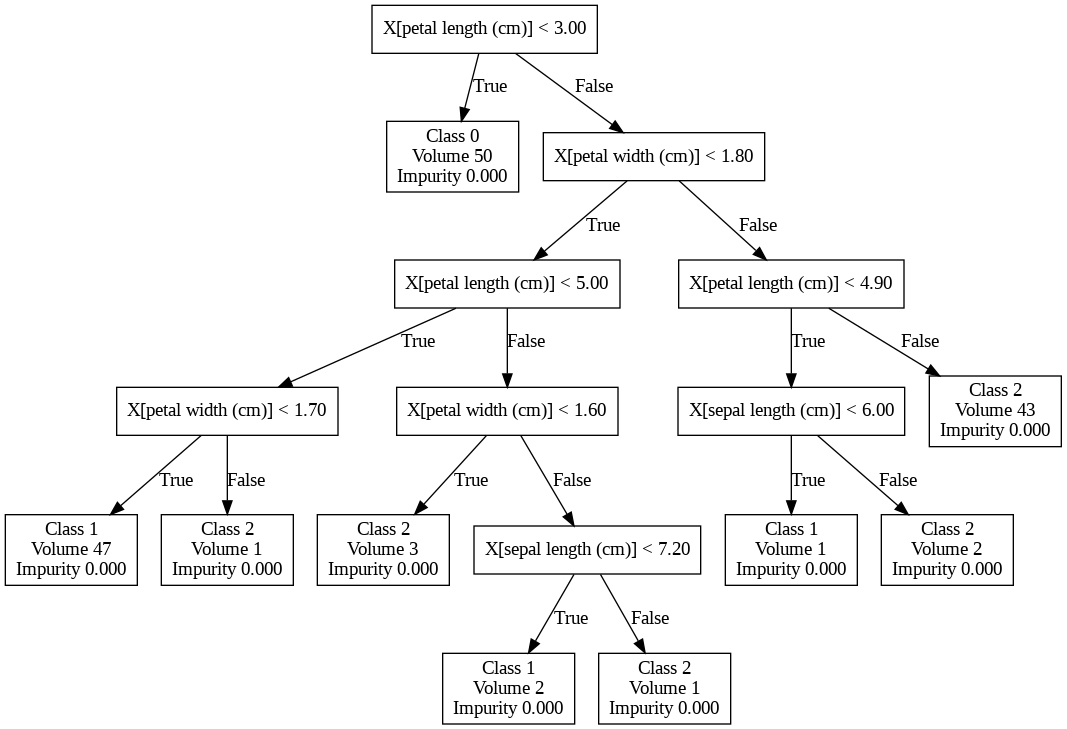

In [ ]:
# Считываем ирисы
iris = datasets.load_iris()
X_ir = pd.DataFrame(iris['data'])
feature_names = iris['feature_names']
y_ir = iris['target']
target_names = iris['target_names']

In [ ]:
# PUT YOUR CODE HERE
X_train_ir, X_test_ir, y_train_ir, y_test_ir = train_test_split(X_ir, y_ir, test_size=0.3)
X_train_ir = X_train_ir.reset_index(drop=True)

def check_acc(X_train, y_train, X_test, y_test):
  my_tree = Tree(max_depth=5, min_samples_leaf=5)
  sk_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

  my_tree.fit(X_train, y_train)
  sk_tree.fit(X_train, y_train)

  my_test_acc = accuracy_score(y_test, my_tree.predict(X_test))
  sk_test_acc = accuracy_score(y_test, sk_tree.predict(X_test))

  print(f"Accuracy:\n  Мое дерево: {my_test_acc}\n  Из коробки: {sk_test_acc}\n")

check_acc(X_train_ir, y_train_ir, X_test_ir, y_test_ir)

Accuracy:
  Мое дерево: 0.9333333333333333
  Из коробки: 0.9333333333333333



#  [Ансамбли](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)




Суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обобщающей способности или надёжности ансамбля перед одиночным стандартным методом машинного обучения.

Можно выделить следующие типы ансамблирования:

* Бэггинг. Однотипная модель строится по различным подвыборкам обучающих данных, затем результаты аггрегируются, например, с помощью усреднения. Для деревьев решений очень распространенным алгоритмом, использующим идею бэггинга, является случайный лес.

* Бустинг. Строится последовательность однотипных моделей, где каждая следующая призвана исправлять ошибки предыдущих. Самым распространенным алгоритмом бустинга является градиентный бустинг.

* Стэкинг. Строится несколько моделей разного типа, а также мета-модель, делающая итоговое предсказание на основании предсказаний моделей.

Для последующих заданий в качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Обратите внимание, что данные нуждаются в небольшой предобаботке, так как деревья работают только с числовыми признаками.


### Задание 2.1

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи бэггинга:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализуйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества и другие. Выберите метрику, по которой вы будете сравнивать качество алгоритмов и кратко обоснуйте, почему вы выбрали именно её (в письменном формате).

Нельзя использовать готовую реализацию случайного леса из `sklearn`, но можно сопоставлять с ней качество вашего алгоритма.



In [ ]:
# PUT YOUR CODE HERE
churn = pd.read_csv('churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
churn = pd.get_dummies(churn, columns=['Geography', 'Gender'], dtype=int)
churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
X_ch = churn.drop('Exited', axis=1)
y_ch = churn['Exited']
X_train_ch, X_test_ch, y_train_ch, y_test_ch = train_test_split(X_ch, y_ch, test_size=0.3, random_state=42)
X_train_ch = X_train_ch.reset_index(drop=True)
y_train_ch = y_train_ch.reset_index(drop=True)
X_test_ch = X_train_ch.reset_index(drop=True)
y_test_ch = y_train_ch.reset_index(drop=True)
X_train_ch

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,32,4,175406.13,2,1,1,172792.43,0,0,1,1,0
1,643,34,7,160426.07,1,0,1,188533.11,0,1,0,1,0
2,561,33,6,0.00,2,0,0,173680.39,1,0,0,0,1
3,618,41,8,37702.79,1,1,1,195775.48,0,1,0,0,1
4,714,37,9,148466.93,2,0,1,151280.96,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,768,54,8,69712.74,1,1,1,69381.05,1,0,0,0,1
6996,682,58,1,0.00,1,1,1,706.50,1,0,0,1,0
6997,735,38,1,0.00,3,0,0,92220.12,1,0,0,1,0
6998,667,43,8,190227.46,1,1,0,97508.04,1,0,0,0,1


In [ ]:
class RandomForest:

  # Инициализация
  def __init__(self, n_trees=100, max_depth=5, min_samples_leaf=1, k=None):
    self.n_trees = n_trees                                              # кол-во деревьев
    self.max_depth = max_depth                                          # макс глубина
    self.min_samples_leaf = min_samples_leaf                            # мин кол-во эл-ов в листе
    self.k = k                                                          # параметр k
    self.all_trees = []                                                 # все деревья

  # бутстрап
  def _bootstrap(self, X, y):
    N = len(X)
    inds = np.random.choice(N, N, replace=True)                         # генерируем индексы
    return X.iloc[inds].reset_index(drop=True), y[inds].reset_index(drop=True)

  def fit(self, X, y):
    self.trees = []
    self.k = int(X.shape[1]**0.5)

    for i in range(self.n_trees):
      X_now, y_now = self._bootstrap(X, y)

      tree =  DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf,
                                     max_features=self.k, criterion='entropy')
      tree.fit(X_now, y_now)
      self.trees.append(tree)

  def predict(self, X):
    # предсказания всех деревьев
    all_predictions = np.array([tree.predict(X) for tree in self.trees]).T

    final_pred = []
    for row in all_predictions:
      unique, counts = np.unique(row, return_counts=True)
      final_pred.append(unique[np.argmax(counts)])
    return np.array(final_pred)


  # вероятность класса предсказанного значения (для метрики roc-auc)
  def predict_proba(self, X):
    all_predictions = np.array([tree.predict(X) for tree in self.trees])
    n_classes = len(np.unique(all_predictions))
    probas = np.zeros((X.shape[0], n_classes))

    for i in range(X.shape[0]):
      counts = np.bincount(all_predictions[:, i].astype(int),
                                minlength=n_classes)
      probas[i] = counts / self.n_trees

    return probas

`МЕТРИКА`

Для ансамблей хорошо подходит метрика **ROC-AUC**. Она не просто оценивает "угадал/не угадал", а насколько уверенно модель разделяет классы. Ансамбли применяют голосование деревьев при классификации, что по факту является вероятностью, какой класс наиболее вероятен. ROC-AUC как раз с вероятностями и работает. Метрика проверяет, насколько чётко эти вероятности отличают один класс от другого, также хорошо работает при несбалансированных данных.

Для ее расчета был прописан метод predict_proba(X), он высчитывает вероятность того, что выбранный класс "победил" (кол-во деревьев, которые его выбрали / всего кол-во деревьев).

In [ ]:
# Параметры для перебора
def params(X, y):
  n_trees_list = [10, 25, 50, 100, 150]
  max_depth_list = [5, 10, None]
  min_samples_leaf_list = [1, 3, 5]

  best_roc = 0
  best_params = {}
  X_full, y_full = X.copy(), y.copy()

  for n_trees in n_trees_list:
    for max_depth in max_depth_list:
      for min_samples_leaf in min_samples_leaf_list:
        roc = []
        for i in range(5):
          X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)
          X_train = X_train.reset_index(drop=True)
          y_train = y_train.reset_index(drop=True)
          rf = RandomForest(n_trees=n_trees, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
          rf.fit(X_train, y_train)
          roc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

        mean_roc = np.mean(roc)
        if mean_roc > best_roc:
          best_roc = mean_roc
          best_params = {'n_trees': n_trees, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

  return best_params, best_roc

In [ ]:
best_params, best_roc = params(X_ch, y_ch)
best_params, best_roc

({'n_trees': 150, 'max_depth': None, 'min_samples_leaf': 5},
 np.float64(0.857761922168702))

In [ ]:
my_ans = RandomForest(**best_params)
sk_ans = SklearnRF(n_estimators=best_params['n_trees'],
                   max_depth=best_params['max_depth'],
                   min_samples_leaf=best_params['min_samples_leaf'], random_state=42)

my_ans.fit(X_train_ch, y_train_ch)
sk_ans.fit(X_train_ch, y_train_ch)

my_proba = my_ans.predict_proba(X_test_ch)[:, 1]
sk_proba = sk_ans.predict_proba(X_test_ch)[:, 1]

my_test_roc = roc_auc_score(y_test_ch, my_proba)
sk_test_roc = roc_auc_score(y_test_ch, sk_proba)

print(f"Accuracy:\n  Мой ансамбль: {my_test_roc}\n  Из коробки: {sk_test_roc}\n")


Accuracy:
  Мой ансамбль: 0.9827250483294169
  Из коробки: 0.9712693542549675



## Задание 2.2

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента. Можно, например, использовать [SHAP](https://habr.com/ru/companies/wunderfund/articles/739744/) для анализа. Также основные способы для определения важности признаков моделей "из коробки" [описаны здесь](https://machinelearningmastery.com/calculate-feature-importance-with-python/).

In [ ]:
explainer = shap.TreeExplainer(my_ans.trees[0], data=X_train_ch)
shap_values = explainer.shap_values(X_test_ch)


In [ ]:
import shap

model = RandomForest(n_trees=30, max_depth=7, min_samples_leaf=5)

model.fit(X_train_ch, y_train_ch)

def predict(X):
    return my_ans.predict(X)

X_part = shap.utils.sample(X_train_ch, 75)

explainer = shap.KernelExplainer(predict, X_test_ch)
shap_values = explainer.shap_values(X_test_ch)

shap.summary_plot(shap_values, X_part, feature_names=X_test_ch.columns, plot_type="bar")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

  0%|          | 0/7000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

KeyboardInterrupt: 

<ipython-input-46-e96e3049e506>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, plot_type="bar", show=False)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1600x600 with 0 Axes>

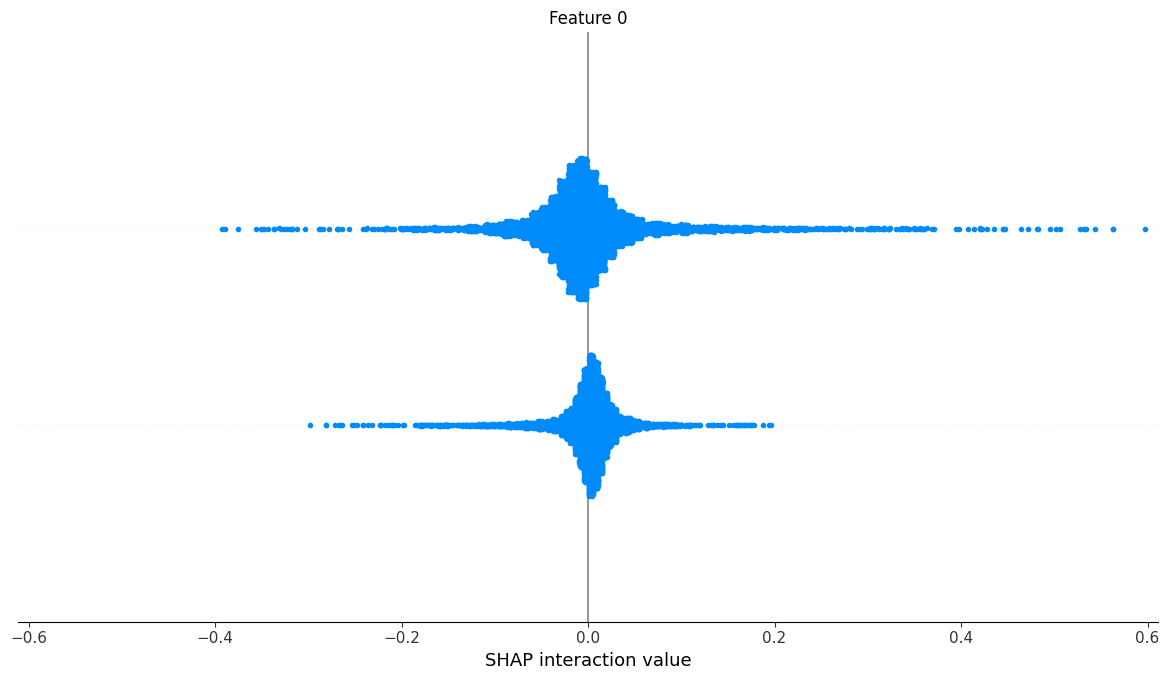

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values, plot_type="bar", show=False)

## Задание 3.1

Вам необходимо будет реализовать алгоритм градиентного бустинга. В общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Для работы алгоритма помимо данных нужны:
1. количество итераций $M \in \mathbb{N}$;
2. функция потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (или просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой делается бустинг - будем использовать деревья решений;
4. начальное приближение $f_0(x)$ - чаще всего используют некую константу.

**Алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно для $t$ от 1 до $M$:
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Находим оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$
    4. Обновляем текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
    5. Собираем все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$
    
    
  Коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице. Однако подбор коэффициентов позволит получить более точные значения, хотя и дополнительно нагрузит алгоритм с вычислительной точки зрения. Коэффициенты выбираются из какого-либо подмножества значений от -1 до 1.

**Функции потерь:**
- $L(y, f) = \frac{1}{2}(y - f)^2$ - _MSE-loss_. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - _MAE-loss_. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать.
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \largeесли\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \largeесли\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - $L_q$-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.


Реализуйте предложенные функции потерь и их градиенты. В случае, если в вашей выборке не один объект, не забывайте нормировать значения функции потерь.


In [ ]:
def mse(y_real, y_predicted):
  return np.mean((y_real - y_predicted)**2)

def mse_gradient(y_real, y_predicted):
  return 2*(y_predicted - y_real)

def mae(y_real, y_predicted):
  return np.mean(np.abs(y_real - y_predicted))

def mae_gradient(y_real, y_predicted):
  return np.sign(y_predicted - y_real)

def lq(y_real, y_predicted, q=0.5):
    errors = y_real - y_predicted
    return np.mean(np.where(errors <= 0, (1-q)*np.abs(errors), q*np.abs(errors)))

def lq_gradient(y_real, y_predicted, q=0.5):
  arr = np.ones(y_real.size)
  condition = y_real <= y_predicted
  arr[condition] = q
  arr[~condition] = q - 1
  return arr

In [ ]:
y_real = np.array([1, 2, 3, 4, 5])
y_predicted = np.array([1.2, 2.5, 2.8, 3.9, 5.1])

# Calculate metrics
mse_result = mse(y_real, y_predicted)
mae_result = mae(y_real, y_predicted)
lq_result = lq(y_real, y_predicted, q=0.8)

# Calculate gradients
mse_grad = mse_gradient(y_real, y_predicted)
mae_grad = mae_gradient(y_real, y_predicted)
lq_grad = lq_gradient(y_real, y_predicted, q=0.8)

# Tests
assert np.isclose(mse_result, 0.07)
assert np.isclose(mae_result, 0.21, rtol=1e5)
assert np.isclose(lq_result, 0.08, rtol=1e5)
assert np.allclose(mse_grad, np.array([0.4, 1, -0.4, -0.2, 0.2]))
assert np.allclose(mae_grad, np.array([1, 1, -1, -1, 1]))
assert np.allclose(lq_grad, np.array([0.8, 0.8, -0.2, -0.2, 0.8]))

print("Tests passed successfully!")

Tests passed successfully!


Реализуйте алгоритм градиентного бустинга со следующими параметрами:

* список, в котором вы будете хранить обученные деревья;
* параметры конструктора для деревьев (tree_kwargs);
* функция потерь;
* градиент функции потерь;
* bool параметр, означающий, является ли $\rho_i$ константой (единицей).

И методами:
* `fit` - в рамках этого метода вам необходимо будет строить деревья. Не забывайте передавать tree_kwargs;
* `predict` - этот метод должен последовательно применить обученные деревья для получения итогового ответа.

В качестве базового алгоритма используйте DecisionTreeRegressor из sklearn. Обычно для градиентного бустинга используют так называемые "пеньки" - деревья небольшой глубины. Это связано с тем, что алгоритм должен иметь высокую обобщающую способность и не переобучаться.


In [ ]:
losses = {
    'MSE': (mse, mse_gradient),
    'MAE': (mae, mae_gradient),
    'lq': (lq, lq_gradient),
}


class GradientTreeBoosting:
  def __init__(self, loss='MSE', iterations=100, const_p=True, tree_kwargs={'max_depth': 3}):
    self.loss_func, self.loss_grad = losses[loss]                   # находим с помощью написанных функций и словарику функцию потерь ее градиент
    self.tree_kwargs = tree_kwargs                                  # араметкторпараметры для деревьев
    self.M = iterations                                           # кол-во итераций/деревьев
    self.trees = []                                                 # список обученных деревьев
    self.p_is_const = const_p                                       # bool параметр, означающий, является ли  ρi  константой (единицей)
    self.all_p = []                                                 # список всех ρi
    self.f0 = None                                                  # начальное приближение функции  f(x)


  def fit(self, X, y):
    self.f0 = np.mean(y)
    current_pred  = np.full_like(y, self.f0, dtype=float)            # текущее приближение (в начале равны начальному приближению f0)

    for i in range(self.M):
      r = -self.loss_grad(y, current_pred)                           # остатки

      tree = DecisionTreeRegressor(**self.tree_kwargs)
      tree.fit(X, r)
      now_preds = tree.predict(X)

      if self.p_is_const:
        p = 1.0
      else:
        p = self._best_p(y, current_pred, now_preds)

      current_pred += p * tree.predict(X)
      self.trees.append(tree)
      self.all_p.append(p)

  def _best_p(self, y, current_pred, now_preds):
    def loss(p):
      return self.loss_func(y, current_pred + p * now_preds)

    best_p = -2
    best_loss = np.inf
    for i in np.arange(-1, 1.1, 0.01):
      now_loss = loss(i)
      if now_loss < best_loss:
        best_loss = now_loss
        best_p = i
    return best_p

  def predict(self, X):
    pred = np.full(len(X), self.f0, dtype=float)
    for i in range(len(self.trees)):
      pred += self.all_p[i] * self.trees[i].predict(X)
    return pred

## Задание 3.2

Проверим на игрушечном примере, что алгоритм работает. Если ваша реализация отличается от используемой в примере - поправьте код примера. Но результат должен получаться похожим.

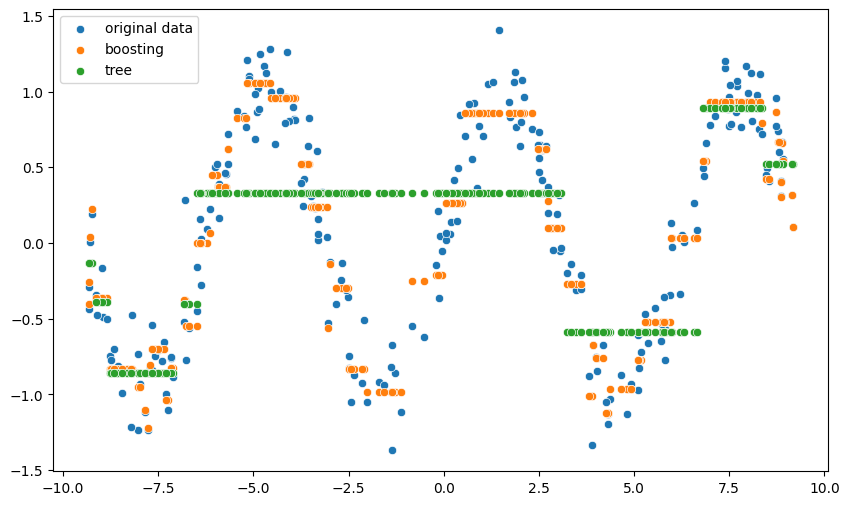

In [ ]:
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=(250))
y = np.sin(x) + np.random.randn(250) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем бустинг-ансамбль
clf = GradientTreeBoosting(loss='MSE', iterations=10, const_p=False,
                           tree_kwargs={'max_depth':3})
clf.fit(x.reshape(-1, 1), y)

# смотрим, что вышло|
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')
plt.show()

Примените алгоритм к тем же данным, с которыми работали в предыдущем задании. Предсказывать будем не класс (0/1), а логиты, то есть вероятность того, что клиент уйдёт, и на основе неё уже делать прогноз, определяя класс относительно некого порога (по умолчанию 0.5).

In [ ]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res


Сравните вашу реализацию градиентного бустинга (с константным $\rho$ и нет) с одиночным DecisionTreeRegressor по качеству и времени выполнения. При неконстантном $\rho$ качество должно возрасти.

In [ ]:
# PUT YOUR CODE HERE
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
  print(name + ':\n')
  model.fit(X_train, y_train)
  logits = %time model.predict(X_test)
  preds = decide_class(logits)

  roc = roc_auc_score(y_test, logits)
  acc = accuracy_score(y_test, preds)

  print(f"  ROC-AUC: {roc:.4f}\n  Accuracy: {roc:.4f}\n")
  return roc, acc

# Одиночный DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_roc, tree_acc = evaluate_model(tree, X_train_ch, y_train_ch, X_test_ch, y_test_ch, "Одиночный DecisionTreeRegressor")

# const_p=True
my_const = GradientTreeBoosting(loss='MSE', iterations=10, const_p=True, tree_kwargs={'max_depth': 3})
const_roc, const_acc = evaluate_model(my_const, X_train_ch, y_train_ch, X_test_ch, y_test_ch, "Градиентный бустинг с константой ρ")

# const_p=False
my_not_const = GradientTreeBoosting(loss='MSE', iterations=10, const_p=False, tree_kwargs={'max_depth': 3})
not_const_roc, not_const_acc = evaluate_model(my_not_const, X_train_ch, y_train_ch,  X_test_ch, y_test_ch, "Градиентный бустинг с подбором ρ")

# Сравнение результатов
print("Улучшение метрики при подборе ρ относительно константы:")
print(f"  ROC-AUC: {not_const_roc - const_roc:.4f}")
print(f"  Accuracy: {not_const_acc - const_acc:.4f}")

Одиночный DecisionTreeRegressor:

CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 2.05 ms
  ROC-AUC: 0.7924
  Accuracy: 0.7924

Градиентный бустинг с константой ρ:

CPU times: user 18.7 ms, sys: 1 ms, total: 19.7 ms
Wall time: 20.1 ms
  ROC-AUC: 0.6482
  Accuracy: 0.6482

Градиентный бустинг с подбором ρ:

CPU times: user 16.1 ms, sys: 1e+03 ns, total: 16.1 ms
Wall time: 16.3 ms
  ROC-AUC: 0.8752
  Accuracy: 0.8752

Улучшение метрики при подборе ρ относительно константы:
  ROC-AUC: 0.2270
  Accuracy: 0.0804
